## Frequency Measurement Result

The following figure depicts the experimental results of measuring running frequencies over `Kyber256.CPA.Decryption`. We extract hints by distinguishing between two different Hamming weights in this leakage.

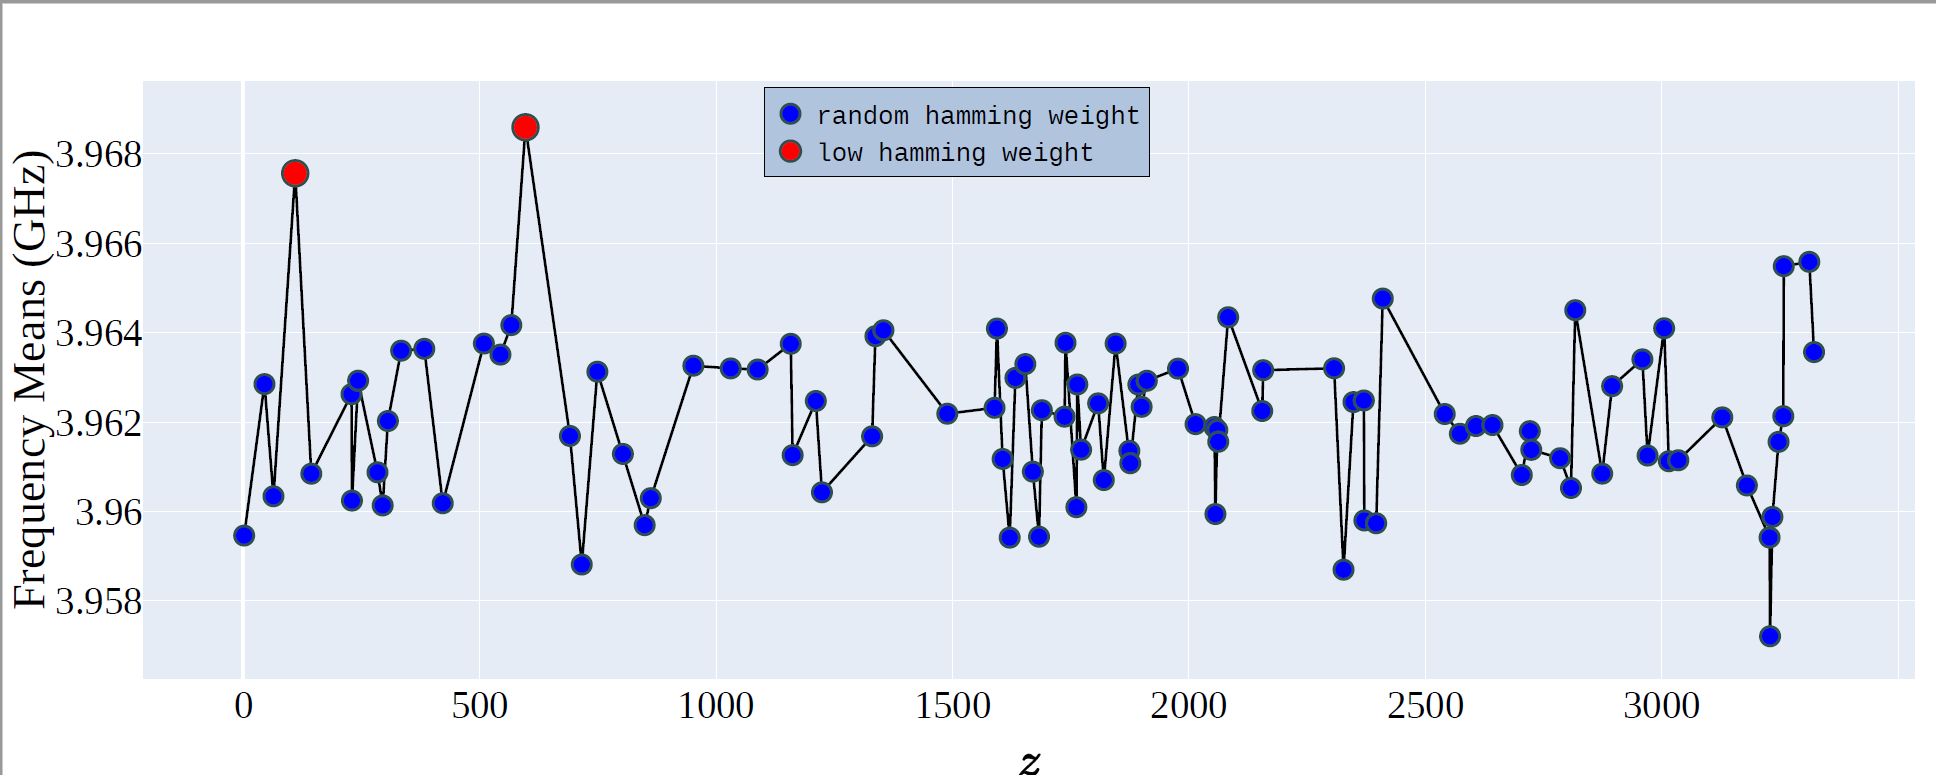

## Constucting Lattice of Kyber 256

In [1]:
from lwe_with_hints import *

In [2]:
# lattice.s

In [3]:
# lattice.shortestVector

In [4]:
# lattice.successBlocksize

In [5]:
# lattice = LWELattice(A,b,q)

In [6]:
ntt_n = 128
KYBER_K = 2

n = KYBER_K *ntt_n
m = n
q = 3329

instance  = "Kyber"+str(n)

In [7]:
A,b,q,s,e = generateLWEInstance(instance)

In [8]:
def experiment(A,b,q,hints,modular,fileName,verbose ):
  
  lattice = LWELattice(A,b,q,verbose=verbose)
  V, L = hints
  ctrHints = len(V)

  print(lattice)
  try:
    start = time.time()
    
    for i in range(ctrHints):
      if modular:
        lattice.integrateModularHint( V[i], L[i] % q, q )
      else:
        lattice.integratePerfectHint( V[i], L[i] )
    
    lattice.reduce(maxBlocksize=40)
    stop = time.time()
    
    output = "Finished experiment.\tHints: %d\tBlocksize: %d\tTime: %fs" % (ctrHints, lattice.successBlocksize, (stop-start))
    print( "\033[94m" + output + "\033[0m" )
    print(lattice.s)
    with open(fileName, "a+") as f:
      print(output, file=f)
      
        
  except Exception:
    #Print exceptions manualy, because Pool may hide them.
    output = traceback.format_exc()
    print(output)
    with open(fileName, "a+") as f:
      print(output, file=f)

### NTT matrix construciton

In [9]:
R = IntegerModRing(3329)
V = VectorSpace(R,ntt_n)

#incomplete ntt
if ntt_n == 128:
    ntt_layer = 6
    zeta = 17^2
elif ntt_n == 64:
    ntt_layer = 5
    zeta = 17^4


import numpy as np

def bit_reverse(x):return 2*int( "0b" + bin(x)[2:].rjust(ntt_layer,'0')[::-1] ,2)+1

NTT_matrix = []

def add (x,y) : return x +y

for x in range(ntt_n/2):
    NTT_matrix.append(V(reduce(add, [[(zeta)^(x*bit_reverse(i)),0] for i in range(ntt_n/2)])))
    NTT_matrix.append(V(reduce(add, [[0,(zeta)^(x*bit_reverse(i))] for i in range(ntt_n/2)])))

NTT_matrix = matrix(NTT_matrix)

inv_NTT_matrix = NTT_matrix^-1

## Simulating Gernerating Hints

In [10]:
s_list = [s[ntt_n*i:ntt_n*(i+1)] for i in range(KYBER_K)]

In [11]:
s_hat_list = [V(list(i))*NTT_matrix for i in s_list]

In [12]:
# Hint_list
s_relation_list = [ [R(s_hat[2*i])/R(s_hat[2*i+1]) for i in range(ntt_n/2)]  for s_hat in s_hat_list]

v_list = []
v_list_1 = []
for j in range(KYBER_K):
    for i in range(ntt_n/2):
        s_relation = s_relation_list[j]
        k = s_relation[i]
        v = list((NTT_matrix.column(2*i) - k*NTT_matrix.column(2*i+1)))
        v = [0]*int(ntt_n*j) + v + [0]*int(ntt_n*(KYBER_K-j-1))
        v_prime  = [int(i) for i in list(v) + [0]*(m)]
    
        v_prime= vec(v_prime)
        v_list.append(v_prime)
        v_list_1.append(v)
        # print(dbdd.leak(v_prime)%3329)

In [13]:
for v0 in v_list_1:
    mul_res = sum([v0[i]* s[i] for i in range(len(v0))])%q
    
    if mul_res!=0:
        assert("hint is wrong")

In [14]:
Hints = (v_list_1,[0]*int(n/2))

## Integrate Hints

In [ ]:
# It will take approximately 2-3 hours.
from multiprocessing import Pool
import time
import traceback

modular = True
verbose = True
fileName ='output.txt'
instances = []
instances.append( (A, b, q, Hints, modular, fileName,verbose) )

pool = Pool()
pool.starmap( experiment, instances )

Constructing basis.
Original dimension 641
Only mod-q hints have been integrated. Going to smaller LWE dimension.
Eliminated dimension 385
Finished basis construction. Time: 0.268488s.
Constructing sublattice.
Finished sublattice construction. Time: 0.000009s.
Starting LLL.
Finished LLL. Time: 154.028316s.
Starting BKZ with blocksize 2.
Finished BKZ with blocksize 2. Time: 5.901054s.
Starting BKZ with blocksize 3.
Finished BKZ with blocksize 3. Time: 238.764121s.
Starting BKZ with blocksize 4.
Finished BKZ with blocksize 4. Time: 6.521608s.
Starting BKZ with blocksize 5.
Finished BKZ with blocksize 5. Time: 260.452707s.
Starting BKZ with blocksize 6.
Finished BKZ with blocksize 6. Time: 6.845005s.
Starting BKZ with blocksize 7.


### Compare the recovered secret with orginal s

When comparing the solved secret with `s`, we can observe that it accurately recovers `s`.

In [ ]:
s

<!-- ## Multiple TEST

We conduct a multi-thread test in `ToyExample_Multiple_Tests_Kyber128x2_with_hints.ipynb(pdf)`

The result can be found in `Multiple_thread_output_1.txt` and `Multiple_thread_output_2.txt"` -->